In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
from hyperopt import fmin, tpe, hp, Trials

from EffectiveXGBoost import *

In [2]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
xg.get_params()

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:62: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

## 15.1 Accuracy

Accuracy is a simple and widely used metric for evaluating classification models. It is useful when all classes are of equal importance and can be calculated as the ratio between the number of correct predictions to the total number of predictions. However, it is important to note that accuracy alone may not always provide a complete picture of a model's performance, especially when working with imbalanced datasets where there is a significant disparity between the number of positive and negative labels.

In [3]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

The default result of calling the `.score` method returns the accuracy of a classification model. 

In [4]:
xgb_def.score(X_test, y_test)

0.7458563535911602

The `accuracy_score` function also shows the same results.

In [5]:
metrics.accuracy_score(y_test, xgb_def.predict(X_test))

0.7458563535911602

## 15.2 Confusion Matrix

A confusion matrix is a table that is used to evaluate the performance of a machine learning model. It shows the number of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions made by the model.

In binary classification problems, the two possible outcomes are typically referred to as the positive class and the negative class. The positive class is the class that represents the presence of a certain condition or attribute, while the negative class represents its absence. For example, in a medical diagnosis problem, the positive class might represent the presence of a disease while the negative class represents its absence.

The terms positive and negative do not imply any value judgment or importance; they are simply labels used to distinguish between the two classes. The choice of which class to label as positive and which to label as negative is often arbitrary and can depend on the context of the problem.

Confusion matrices and other classification performance metrics such as precision and recall are used specifically for classification problems where the goal is to predict a categorical outcome. In regression problems, where the goal is to predict a continuous numerical value, different performance metrics such as mean squared error or R-squared are used instead.

- True Positive (TP): The number of instances where the model correctly predicted the positive class.
- True Negative (TN): The number of instances where the model correctly predicted the negative class.
- False Positive (FP): The number of instances where the model incorrectly predicted the positive class (Type I error).
- False Negative (FN): The number of instances where the model incorrectly predicted the negative class (Type II error).

The confusion matrix can help you calculate other performance metrics such as prevalence, accuracy, precision, and recall. Prevalence is the proportion of positive cases in the population. Accuracy is the proportion of correct predictions made by the model. Precision is the proportion of true positive predictions among all positive predictions made by the model. Recall is the proportion of true positive predictions among all actual positive instances.

In addition to the confusion matrix, there are several other tools and techniques that can be used to evaluate the performance of machine learning models. These include techniques such as ROC curves, precision-recall curves, and calibration plots. These tools can help you gain a deeper understanding of your model's performance and make more informed decisions about how to improve it.


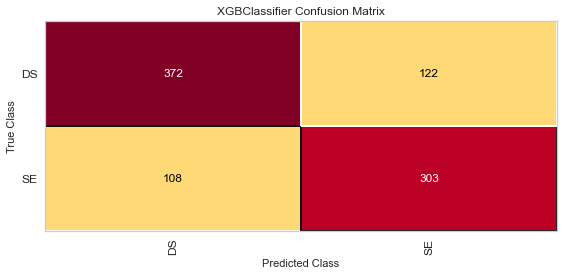

ConfusionMatrix(ax=<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['DS', 'SE'],
                cmap=<matplotlib.colors.ListedColormap object at 0x00000234714F8400>,
                estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                        callbacks=None, colsample_bylevel=1,
                                        colsample_bynode=1, colsample_bytree=1,
                                        early_stopp...
                                        eval_metric=None, gamma=0, gpu_id=-1,
                                        grow_policy='depthwise',
                                        importance_type=None,
                                        interaction_constraints='',
                                        learning_rate=0.300000012, max_bin=256,
                                        max_cat_to_onehot=4, max_delta_step=0,
                                        max_depth=6, max_leaves=0,
                                        min_child_weight=1, missing=nan,
                                        monotone_constraints='()',
                                        n_estimators=100, n_jobs=0,
                                        num_parallel_tree=1, predictor='auto',
                                        random_state=0, reg_alpha=0,
                                        reg_lambda=1, ...))

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.confusion_matrix(xgb_def, X_train, y_train, 
                            X_test, y_test, 
                            classes=['DS', 'SE'], ax=ax)

We can also use scikit-learn to create a NumPy matrix of a confusion matrix.

In [7]:
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test))
cm

array([[372, 122],
       [108, 303]], dtype=int64)

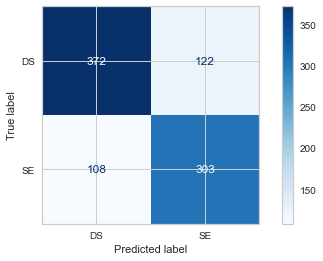

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=['DS', 'SE'])

_=disp.plot(ax=ax, cmap='Blues')

If you prefer to use fractions (which might sometimes make it easier to understand a confusion matrix) instead of
counts, the `normalize='true'` parameter is there to be used.

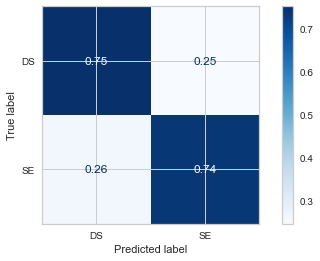

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test),
                              normalize='true')

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['DS', 'SE'])
_=disp.plot(ax=ax, cmap='Blues')

## 15.3 Precision and Recall

Precision measures the proportion of correct positive predictions made by the model divided by all of the positive predictions. We can mathematically represent it as the correct positive guesses all over all positive guesses i.e the fraction of actual positives that the system classified correctly. We need lower false positives in order to have a high precision. 

$$
\frac{TP}{TP + FP}
$$

A system with high precision might leave some good items out but what it returns are items of high quality. If you were a book lover who didn’t have the time to search for books, you’d need a recommender system that had a high precision. The ratio of total number of relevant items found to the total items found by the recommender system.

Recall measures the proportion of actual positive examples that the model correctly predicts. We can mathematically represent it as the correct positive guesses all over all truly positive items ie a proportion of actual positives classified correctly among all the data. We need the system to have a lower false negatives for it to have a high recall.

$$
\frac{TP}{TP+FN}
$$

A system with a high recall might give you a lot of duds but it will also return most of the good items. Recall could be likened to a jewelry burglar, whilst robbing a jewelry store, who would collect all the items that remotely looked like an expensive piece of jewelry. The ratio of the relevant items found to the number of relevant items available.

These two metrics are often at odds with each other, meaning that improving one can reduce the other. The tradeoff between precision and recall depends on the specific needs of the problem being solved.

One additional fact about precision and recall is that they are often used together to evaluate the performance of a binary classification model. A common way to combine these two metrics is by calculating their harmonic mean, known as the F1 score. The F1 score provides a single measure of a model's performance that takes into account both precision and recall.

Another related concept is the Receiver Operating Characteristic (ROC) curve, which plots the true positive rate (recall) against the false positive rate for different classification thresholds. The area under the ROC curve (AUC) is a commonly used performance metric that summarizes the tradeoff between true positive rate and false positive rate for a binary classifier.

### Five examples where high precision may be preferred over high recall:

1. Search engine results: In the case of a search engine, it may be more important to return highly relevant results (high precision) even if it means that some relevant results are not returned (lower recall). Users are more likely to be satisfied with a small number of highly relevant results than with a large number of irrelevant results.

2. Email spam filter: In the case of an email spam filter, it may be more important to correctly identify all non-spam emails (high precision) even if it means that some spam emails make it through the filter (lower recall). The cost of incorrectly identifying a non-spam email as spam (a false positive) can be high, while the cost of missing a spam email (a false negative) is relatively low.

3. Advertising: In advertising, it may be more important to show ads to people who are likely to be interested in the product or service being advertised (high precision) even if it means that some people who might be interested do not see the ad (lower recall). The cost of showing an ad to someone who is not interested (a false positive) can be high, while the cost of missing someone who might be interested (a false negative) is relatively low.

4. Recommender systems: In recommender systems, such as those used by online retailers or streaming services, it may be more important to recommend items that the user is likely to enjoy or find useful (high precision) even if it means that some items that the user might enjoy or find useful are not recommended (lower recall). The cost of recommending an item that the user does not enjoy or find useful (a false positive) can be high, while the cost of missing an item that the user might enjoy or find useful (a false negative) is relatively low.

5. Credit scoring: In credit scoring, it may be more important to correctly identify applicants who are likely to repay their loans on time (high precision) even if it means that some applicants who would repay their loans on time are not approved for credit (lower recall). The cost of approving an applicant who will not repay their loan on time (a false positive) can be high, while the cost of denying credit to an applicant who would repay their loan on time (a false negative) is relatively low.

### Five examples where high recall may be preferred over high precision:

1. Fraud detection: In the case of detecting fraudulent transactions, it may be more important to correctly identify as many fraudulent transactions as possible (high recall) even if it means that some legitimate transactions are incorrectly flagged as fraudulent (lower precision). The cost of missing a fraudulent transaction (a false negative) can be very high, while the cost of flagging a legitimate transaction as fraudulent (a false positive) is relatively low.

2. Disease diagnosis: In medical diagnosis, it may be more important to correctly identify all patients with a certain disease (high recall) even if it means that some healthy patients are incorrectly identified as having the disease (lower precision). The cost of missing a positive case (a false negative) can be very high, while the cost of incorrectly identifying a negative case (a false positive) is relatively low.

3. Natural disaster warning systems: In the case of natural disaster warning systems, it may be more important to correctly warn all people in danger (high recall) even if it means that some people who are not in danger receive a warning (lower precision). The cost of missing a person in danger (a false negative) can be very high, while the cost of warning a person who is not in danger (a false positive) is relatively low.

4. Quality control in manufacturing: In manufacturing, it may be more important to correctly identify all defective products (high recall) even if it means that some non-defective products are incorrectly identified as defective (lower precision). The cost of missing a defective product (a false negative) can be very high, while the cost of incorrectly identifying a non-defective product as defective (a false positive) is relatively low.

5. Criminal investigations: In criminal investigations, it may be more important to correctly identify all potential suspects (high recall) even if it means that some innocent people are investigated (lower precision). The cost of missing a potential suspect (a false negative) can be very high, while the cost of investigating an innocent person (a false positive) is relatively low.

In the case of stock trading using classification to predict whether the market will go up or down, the choice between precision and recall would depend on the specific trading strategy and the relative costs of false positives and false negatives. If the trading strategy involves taking long positions when the market is predicted to go up and short positions when the market is predicted to go down, then a high precision would be important to minimize losses from incorrect predictions. In this case, a false positive (predicting an up day when it is actually a down day) would result in a loss from a long position, while a false negative (predicting a down day when it is actually an up day) would result in a loss from a short position. The relative costs of these two types of errors would depend on the specifics of the trading strategy and the market conditions.

On the other hand, if the trading strategy involves taking long positions only when there is a high degree of confidence that the market will go up, then a high recall may be more important to capture as many profitable opportunities as possible. In this case, a false negative (failing to predict an up day) would result in a missed opportunity for profit, while a false positive (incorrectly predicting an up day) would have no impact if no position is taken.

Risk to Reward ratio is key.


Let us visualize the tradeoff between these two measures, using a `precision-recall` curve
found in Yellowbrick.

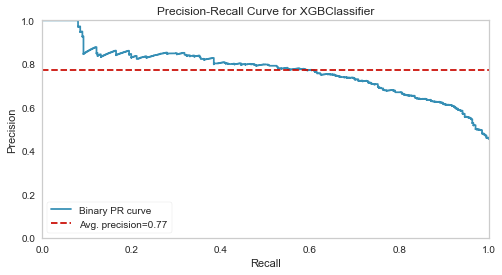

(0.0, 1.05)

In [12]:
from yellowbrick import classifier
fig, ax = plt.subplots(figsize=(8, 4))

classifier.precision_recall_curve(xgb_def, X_train, 
                                  y_train, X_test, y_test, micro=False, macro=False, ax=ax, per_class=True)

ax.set_ylim((0,1.05))


A `precision-recall` curve, is a plot that shows the tradeoff between precision and recall for different probability thresholds. Many machine learning models have a `.predict_proba` method that returns a probability for both positive and negative labels rather than just a single label or value for prediction. By changing the threshold for assigning a label, one can produce a model with different levels of precision and recall. For example, if the probability of the positive label is above a threshold of .98, the model would assign the positive label. This would likely produce a model with high precision and low recall (a point on the upper left of the plot). By loosening this threshold from .98 down to .01 and tracking both precision and recall, one can produce the precision-recall plot.

It is important to note that a high area under the precision-recall curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). This plot can help you understand how your model might perform given different considerations such as minimizing false positives or maximizing true positives.

## 15.4 F1 Score

The F1 score is the harmonic mean of precision and recall. The F1 score is a measure of a test's accuracy that considers both precision and recall. It is calculated as the harmonic mean of precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. The F1 score is particularly useful when you want to strike a balance between precision and recall, as it provides a single number that can help describe the performance of a classifier in terms of both metrics.

In [13]:
metrics.f1_score(y_test, xgb_def.predict(X_test))

0.7248803827751197

In [14]:
print(metrics.classification_report(y_test,
                                    y_pred=xgb_def.predict(X_test), 
                                    target_names=['DS', 'SE']))

              precision    recall  f1-score   support

          DS       0.78      0.75      0.76       494
          SE       0.71      0.74      0.72       411

    accuracy                           0.75       905
   macro avg       0.74      0.75      0.74       905
weighted avg       0.75      0.75      0.75       905



The classification report provided by scikit-learn is a useful tool for evaluating the performance of a classifier. It provides a summary of the main classification metrics, including precision, recall, and F1-score, for each class as well as their macro and weighted averages. 

* The `macro average` is the average of the class behavior, calculated by taking the average of the metric for each class without considering the class imbalance. 

* The `weighted average` is based on the count (support), calculated by taking the average of the metric for each class while considering the class imbalance. This means that classes with more samples have a greater influence on the weighted average than classes with fewer samples.

By analyzing these metrics, you can gain insight into how well your classifier is performing in terms of correctly identifying positive and negative samples, as well as how well it is balancing the tradeoff between precision and recall.

For example, if you have a binary classification problem with imbalanced classes, you may want to pay close attention to the precision and recall values for the minority class. A low recall value for the minority class may indicate that your classifier is struggling to correctly identify positive samples from that class. Similarly, a low precision value for the minority class may indicate that your classifier is incorrectly labeling negative samples from the majority class as positive.

In summary, the classification report can help you identify areas where your classifier may be underperforming and guide you in making improvements to your model.

The Yellowbrick library also provides a classification report. This report provides a visual summary of the main classification metrics, including precision, recall, and F1-score, for both positive and negative labels. Like the classification report provided by scikit-learn, the Yellowbrick classification report can help you evaluate the performance of your classifier and identify areas where it may be underperforming. The visual nature of the report makes it easy to quickly assess the performance of your classifier and compare it to other models or benchmarks.

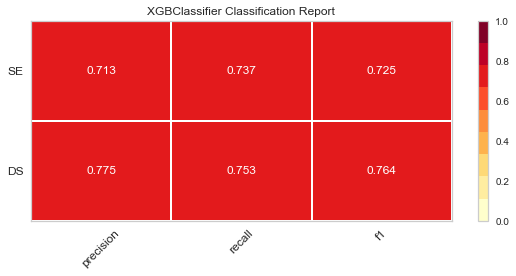

ClassificationReport(ax=<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>,
                     classes=['DS', 'SE'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x00000234002C2DF0>,
                     estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                             callbacks=None,
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1,
                                             early_stopping_rounds=None,
                                             enable_categorica...
                                             eval_metric=None, gamma=0,
                                             gpu_id=-1, grow_policy='depthwise',
                                             importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.300000012,
                                             max_bin=256, max_cat_to_onehot=4,
                                             max_delta_step=0, max_depth=6,
                                             max_leaves=0, min_child_weight=1,
                                             missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=100, n_jobs=0,
                                             num_parallel_tree=1,
                                             predictor='auto', random_state=0,
                                             reg_alpha=0, reg_lambda=1, ...))

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

classifier.classification_report(xgb_def, X_train, y_train,
        X_test, y_test, classes=['DS', 'SE'],
        micro=False, macro=False, ax=ax)


## 15.5 ROC Curve

The _Receiver Operating Characteristic_ (ROC) curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve was first used during World War II to understand how effective radar signals were at detecting enemy aircraft. It measures the true positive rate (or recall) against the false positive rate (or fallout, false positive count divided by the count of all negatives) over a range of thresholds.

One interesting fact about ROC curves is that they are widely used in medicine, radiology, and other fields for evaluating diagnostic tests. For example, an ROC curve can be used to evaluate the accuracy of a blood test for detecting a disease. Another fact is that the area under the ROC curve (AUC) provides an aggregate measure of performance across all possible classification thresholds. A model with perfect predictive ability will have an AUC of 1, while a model with no predictive ability will have an AUC of 0.5.

Let’s look at an example and then explain it. We will plot two ROC curves on the same
plot—one from the default XGBoost model and the other from our Hyperopt-trained model.
We will use the scikit learn library `RocCurveDisplay.from_estimator` method.

In [17]:
step_params = {'random_state': 42,
    'max_depth': 5,
    'min_child_weight': 0.6411044640540848,
    'subsample': 0.9492383155577023,
    'colsample_bytree': 0.6235721099295888,
    'gamma': 0.00011273797329538491,
    'learning_rate': 0.24399020050740935}

xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50,
                            n_estimators=500)
xg_step.fit(X_train, y_train, 
            eval_set=[(X_train, y_train),
                      (X_test, y_test)],verbose=100)

xg_step.score(X_test, y_test)

[0]	validation_0-logloss:0.64730	validation_1-logloss:0.65403
[81]	validation_0-logloss:0.36640	validation_1-logloss:0.51755


0.7580110497237569

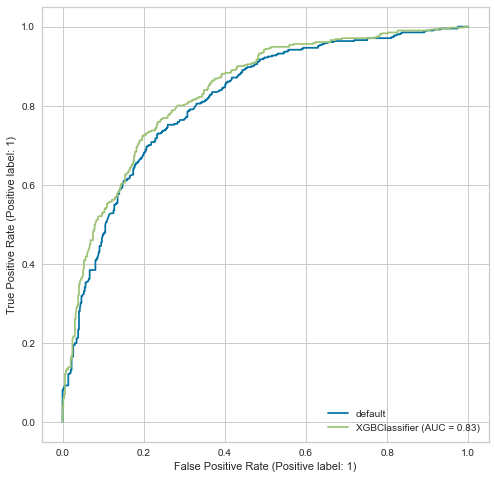

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
metrics.RocCurveDisplay.from_estimator(xgb_def,
X_test, y_test,ax=ax, label='default')
metrics.RocCurveDisplay.from_estimator(xg_step,
X_test, y_test,ax=ax)


A high AUC value is desirable when the cost of false positives and false negatives is similar. In such cases, a high AUC indicates that the model is able to effectively differentiate between positive and negative examples. However, in cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives).

As a rule of thumb, the AUC metric or an ROC plot alone cannot determine if a model is good enough for a specific application. However, they can indicate if a model is performing poorly. An AUC value less than 0.5 suggests that the model performs worse than random guessing. In such cases, it may be beneficial to re-evaluate the model.

If a model reports an AUC of 1 or very close to it, it could indicate one of two things:
* The problem may be very simple and machine learning may not be necessary.
* There could be data leakage in the model, where information that would not be available at the time of prediction is included in the model's training.

Data leakage can occur when data that wouldn't be known when making a prediction is included in the model.
An example of data leakage is building a machine learning model to predict the sentiment of movie reviews and including the movie's rating as a feature in the model's training. When this feature is removed, the accuracy of the model drops.

An ROC curve can be used to determine if one model is better than another at a given threshold. If one model has a higher AUC or its ROC curve bulges out more to the upper left corner, it is considered better. However, being a better model does not necessarily mean it will work for a given business context.

ROC curves can also be used to understand overfitting. If an ROC curve is plotted for both training and testing data, they should look similar. If the training data has a good ROC curve but the testing data has a poor ROC curve, it may indicate overfitting.

An example of data leakage in reality could occur in healthcare when building a predictive model for patient readmissions. If information about future events such as lab results or diagnoses that occur after the initial hospitalization is included in the model's training data, it could result in data leakage and an overly optimistic performance estimate.

Let’s explore that with the default model and the stepwise model.

[Text(0.5, 1.0, 'ROC plots for stepwise model')]

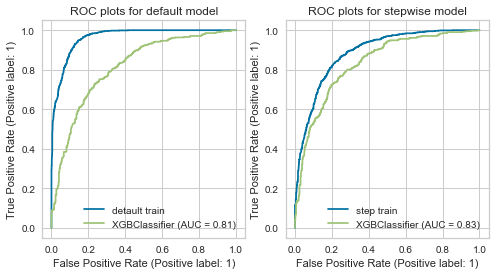

In [20]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
metrics.RocCurveDisplay.from_estimator(xgb_def, 
                                       X_train, y_train,ax=axes[0], label='detault train')
metrics.RocCurveDisplay.from_estimator(xgb_def,
                                       X_test, y_test,ax=axes[0])
axes[0].set(title='ROC plots for default model')
metrics.RocCurveDisplay.from_estimator(xg_step,
                                       X_train, y_train,ax=axes[1], label='step train')
metrics.RocCurveDisplay.from_estimator(xg_step,
                                       X_test, y_test,ax=axes[1])
axes[1].set(title='ROC plots for stepwise model')

The stepwise model has worse training performance than the default model. However, this is because the default model appears to be overfitting. The testing score improves with tuning even though the training score decreases.

## 15.6 Threshold Metrics

In scikit-learn and XGBoost models, the threshold is not exposed as a hyperparameter. However, you can experiment with the threshold by creating a subclass.

In [21]:
class ThresholdXGBClassifier(xgb.XGBClassifier):
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        
    def predict(self, X, *args, **kwargs):
        """Predict with `threshold` applied to predicted class probabilities.
        """
        proba = self.predict_proba(X, *args, **kwargs)
        return (proba[:, 1] > self.threshold).astype(int)

In [22]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
xgb_def.predict_proba(X_test.iloc[[0]])

array([[0.14253652, 0.8574635 ]], dtype=float32)

In [23]:
xgb_def.predict(X_test.iloc[[0]])

array([1])

In [24]:
xgb90 = ThresholdXGBClassifier(threshold=.9, verbosity=0)
xgb90.fit(X_train, y_train)
xgb90.predict(X_test.iloc[[0]])

array([0])

<AxesSubplot:title={'center':'Threshold Metrics'}, xlabel='thresh'>

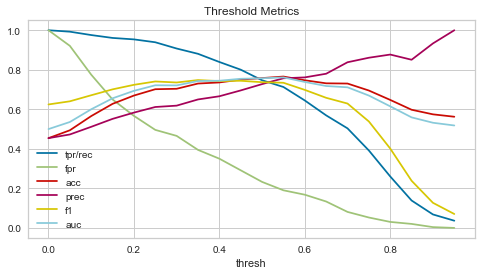

In [25]:
def get_tpr_fpr(probs, y_truth):
    """
    Calculates true positive rate (TPR) and false positive rate
    (FPR) given predicted probabilities and ground truth labels.
    Parameters:
    probs (np.array): predicted probabilities of positive class
    y_truth (np.array): ground truth labels
    Returns:
    tuple: (tpr, fpr)
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr

vals = []
for thresh in np.arange(0, 1, step=.05):
    probs = xg_step.predict_proba(X_test)[:, 1]
    tpr, fpr = get_tpr_fpr(probs > thresh, y_test)
    val = [thresh, tpr, fpr]
    for metric in [metrics.accuracy_score, metrics.precision_score,
                    metrics.recall_score, metrics.f1_score,
                    metrics.roc_auc_score]:
        val.append(metric(y_test, probs > thresh))
    vals.append(val)
    
fig, ax = plt.subplots(figsize=(8, 4))
(pd.DataFrame(vals, columns=['thresh', 'tpr/rec', 
                             'fpr', 'acc', 'prec', 'rec', 'f1', 'auc'])
 .drop(columns='rec')
 .set_index('thresh')
 .plot(ax=ax, title='Threshold Metrics')
)

## 15.7 Cumulative Gains Curve
The Cumulative Gains Curve is useful for maximizing marketing response rates when resources are finite. It plots the gain (recall or sensitivity) against the ordered samples. The baseline represents the gain that would be achieved with random predictions. The gain is calculated as the true positive rate if the predictions were ordered by probability against the percentage of samples.

In a Cumulative Gains Curve, gain is calculated as the true positive rate if the predictions were ordered by probability against the percentage of samples. This means that the gain represents the proportion of positive instances that were correctly identified by the model up to a certain point in the ordered list of predictions.

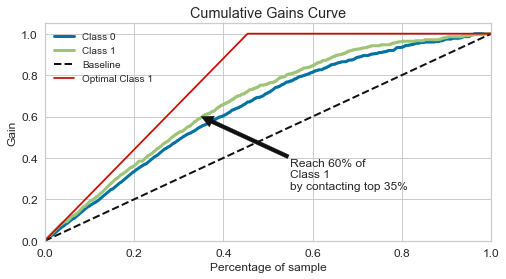

In [27]:
import scikitplot
fig, ax = plt.subplots(figsize=(8, 4))

y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)
ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')
ax.set_ylim(0, 1.05)
ax.annotate('Reach 60% of\nClass 1\nby contacting top 35%', xy=(.35, .6),
            xytext=(.55,.25), arrowprops={'color':'k'})
_=ax.legend()

Here is a breakdown of the code block:

1. `import scikitplot`: This line imports the scikitplot library.
2. `fig, ax = plt.subplots(figsize=(8, 4))`: This line creates a figure with a single subplot and sets the figure size to 8 by 4 inches.
3. `y_probs = xgb_def.predict_proba(X_test)`: This line uses the `xgb_def` model to predict the probabilities of the test data and stores the result in the `y_probs` variable.
4. `scikitplot.metrics.plot_cumulative_gain(y_test, y_probs, ax=ax)`: This line uses the `plot_cumulative_gain` function from the scikitplot library to plot a Cumulative Gains Curve on the specified axes. The function takes as input the true labels of the test data and the predicted probabilities.
5. `ax.plot([0, (y_test == 1).mean(), 1], [0, 1, 1], label='Optimal Class 1')`: This line adds an optimal line to the plot, representing the gain that would be achieved with a perfect model.
6. `ax.set_ylim(0, 1.05)`: This line sets the y-axis limit to slightly above 1.
7. `ax.annotate('Reach 60% of\nClass 1\nby contacting top 35%', xy=(.35, .6), xytext=(.55,.25), arrowprops={'color':'k'})`: This line adds an annotation to the plot indicating that 60% of Class 1 can be reached by contacting the top 35% of samples.
8. `ax.legend()`: This line adds a legend to the plot.


## 15.8 Lift Curves
The Lift Curve is a plot showing the true positive rate and the cumulative positive rate of a machine learning model as the prediction threshold varies. It uses the same x-axis as the Cumulative Gains plot but the y-axis represents the ratio of gains to randomly choosing a label. This indicates how much better the model is than guessing. For example, if you can only reach the top 20% of your audience, you should be almost 1.8x better than randomly choosing labels.

A Lift Curve is useful for evaluating a model when resources are finite and can help determine how much better a model is than random guessing. It can also be used to compare different models and determine which one performs better at a given threshold.

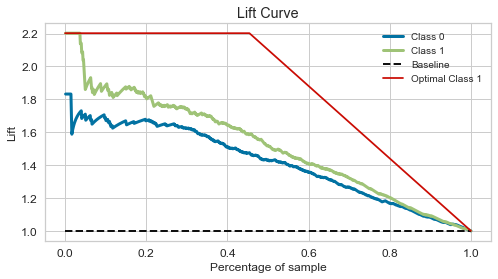

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
y_probs = xgb_def.predict_proba(X_test)
scikitplot.metrics.plot_lift_curve(y_test, y_probs, ax=ax)
mean = (y_test == 1).mean()
ax.plot([0, mean, 1], [1/mean, 1/mean, 1], label='Optimal Class 1')
ax.legend()

## Summary
1. Cross-validation is a technique used to evaluate the performance of a machine learning model by partitioning the data into subsets and training the model on one subset while testing it on another. This process is repeated multiple times with different partitions of the data. The average performance across all iterations is used to estimate the model's performance on unseen data.

2. Precision and recall are two metrics used to evaluate the performance of a machine learning model. Precision measures the proportion of true positive predictions among all positive predictions made by the model. Recall measures the proportion of true positive predictions among all actual positive instances in the data. In other words, precision measures how many of the positive predictions made by the model are correct, while recall measures how many of the actual positive instances were correctly identified by the model.

3. The F1 score is a measure of a model's accuracy that combines precision and recall. It is calculated as the harmonic mean of precision and recall and ranges from 0 to 1, with 1 indicating perfect precision and recall. The F1 score is commonly used to evaluate models when there is an uneven class distribution or when the cost of false positives and false negatives is not equal.

4. The appropriate metric to use when evaluating a machine learning model depends on the specific problem and context. Precision may be more appropriate when the cost of false positives is high, while recall may be more appropriate when the cost of false negatives is high. Accuracy may be more appropriate when the class distribution is balanced and the cost of false positives and false negatives is equal. The F1 score may be more appropriate when there is an uneven class distribution or when the cost of false positives and false negatives is not equal.

5. A ROC curve (Receiver Operating Characteristic curve) is a graphical representation of a model's performance at different classification thresholds. It plots the true positive rate against the false positive rate at different thresholds, allowing for visual comparison of different models or selection of an optimal threshold for a given model. The area under the ROC curve (AUC) can also be used as a single-number summary of a model's performance.

6. ROC curves, precision-recall curves, and lift plots can be used to improve, optimize, and maximize the performance of a machine learning model by providing visual representations of its performance at different classification thresholds or operating points. These plots can help identify optimal thresholds or operating points for a given problem or context, allowing for fine-tuning of the model's performance.